<a href="https://colab.research.google.com/github/Mulac/TDA-MNIST/blob/master/4_Convolutional_Layer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook will visualise the filters in each layer of a 4-convolutional layer CNN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np 
import matplotlib.pyplot as plt
from skimage.util import random_noise
from time import perf_counter

## Prepare Data
1. Download data and apply tranformations

In [ ]:
tfms_train = transforms.Compose([transforms.Resize(size=28),
                           transforms.ToTensor()
                           ])
tfms_valid = transforms.ToTensor()


In [ ]:
train = torchvision.datasets.MNIST('./data/train', train=True, transform=tfms, download=True)
valid = torchvision.datasets.MNIST('./data/valid', train=False,transform=tfms1, download=True)

## Create Model
Two ways to do this.  Either by inheriting from the Module class or by using nn.Sequential

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    ## 4- convolutional layer CNN

    # convolution layer 1 -> convolutional layer 2 -> maxpool -> convolutional layer 3 -> dropout layer -> convolutional layer 4 -> maxpool -> linear 1 -> linear 2
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1)
    self.linear1 = nn.Linear(64*3*3, 128) 
    self.linear2 = nn.Linear(128, 10) 
    self.drop = nn.Dropout2d(0.4)

  
  def forward(self, input):
      result = self.conv1(input)
      result = F.relu(result)
  
      result = self.conv2(result)
      result = F.relu(result)
      result = self.pool(result)

      result = self.conv3(result)
      result = F.relu(result)

      result = self.drop(result)

      result = self.conv4(result)
      result = F.relu(result)
      result = self.pool(result)

      result = result.view(result.size(0), -1)
      result = self.linear1(result)
      result = self.linear2(result)

      return result


### Define training loop

Grab batch from data loader; make model predictions; calculate loss; compute gradients; update weights;

**Data augmentation takes place here**

In [ ]:
class Learner():
  
  def __init__(self, model, lr, train, valid):
    self.model = model
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
    self.criterion = torch.nn.CrossEntropyLoss()
    self.train_loader = train
    self.valid_loader = valid
  
  def fit(self, epochs):
    for e in range(epochs):
      start = perf_counter()
      self.train()
      end = perf_counter()
      print("epoch", (e + 1), " | accuracy", round(self.eval(),3), "% | time: ", round((end-start),3), " seconds")

  def train(self):
    self.model.train()

    for images, labels in self.train_loader:
      predictions = self.model(images)
      loss = self.criterion(predictions, labels)

      loss.backward()
      self.optimizer.step()
      self.optimizer.zero_grad()
    
      aug_images = self.augment_images(images)
      predictions = self.model(aug_images)
      loss = self.criterion(predictions, labels)

      loss.backward()
      self.optimizer.step()
      self.optimizer.zero_grad()

  def augment_images(self, images):
    for img in images:
      aug_img = transforms.ToPILImage()(img)
      aug_img = transforms.RandomAffine(degrees = 15, translate = (0.2,0.2), scale = (0.5,1))(aug_img)
      aug_img = transforms.ToTensor()(aug_img)
      img = torch.from_numpy(random_noise(aug_img, mode='gaussian', mean=0, var=0.05, clip=True, seed = 63))
    return images


  def eval(self):
    self.model.eval()

    with torch.no_grad():
      correct = 0
      for images, labels in self.valid_loader:
        predicted = torch.argmax(self.model(images),dim=1)
        correct += (predicted == labels).sum().item()

    return correct / len(self.valid_loader.dataset) * 100

  def confusion_matrix(self):
    self.model.eval()
    confusion_matrix = np.array([[0]*10]*10)

    with torch.no_grad():
      for image, label in self.valid_loader:
        pred = torch.argmax(self.model(image), dim=1)
        confusion_matrix[label][pred] += 1
    
    return confusion_matrix

### Choose loss function and optimiser
e.g. Mean Squared Error (MSE) with Stochastic Gradient Decent (SGD)

In [ ]:
BATCH_SIZE = 5
valid_loader = torch.utils.data.DataLoader(valid)
criterion = torch.nn.CrossEntropyLoss()

### Execute training loop
Can be in a for loop for multiple epochs (number of passes through the whole dataset)

In [ ]:
def plot_accuracy(matrix):
  fig, ax = plt.subplots()
  im = ax.imshow(matrix)
  axis = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  # Showing all ticks
  ax.set_xticks(np.arange(10))
  ax.set_yticks(np.arange(10))
  # Giving labels to ticks and axes
  ax.set_xticklabels(axis)
  ax.set_yticklabels(axis)
  ax.set_ylabel('Actual')
  ax.set_xlabel('Prediction')
  # Creating text annotations for each cell
  for i in range(10):
      for j in range(10):
          text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w")
  ax.set_title("Model Predictions vs Actual")
  fig.tight_layout()
  return plt.show()

In [ ]:
  model = CNN()
  learner = Learner(model, 0.001, torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle=False), valid_loader)
  learner.fit(15)
  plot_accuracy(learner.confusion_matrix())

epoch 1  | accuracy 94.49 % | time:  296.047  seconds
epoch 2  | accuracy 96.65 % | time:  296.706  seconds
epoch 3  | accuracy 96.99 % | time:  294.081  seconds
epoch 4  | accuracy 97.15 % | time:  295.427  seconds
epoch 5  | accuracy 97.98 % | time:  292.929  seconds
epoch 6  | accuracy 98.03 % | time:  290.695  seconds
epoch 7  | accuracy 98.12 % | time:  294.673  seconds
epoch 8  | accuracy 98.26 % | time:  295.087  seconds
epoch 9  | accuracy 98.31 % | time:  294.58  seconds
epoch 10  | accuracy 98.42 % | time:  293.22  seconds
epoch 11  | accuracy 98.42 % | time:  295.071  seconds
epoch 12  | accuracy 98.42 % | time:  294.471  seconds
epoch 13  | accuracy 98.33 % | time:  293.497  seconds
epoch 14  | accuracy 98.63 % | time:  293.449  seconds
epoch 15  | accuracy 98.62 % | time:  294.001  seconds


NameError: ignored

## Visualisation

We create a class that allows us to inspect individual layers in our neural network using hooks.

In [ ]:
class LayerVisualisation():
  """ 
    Allows us to inspect an indivdual convolutional layer in a neural network.
  """

  def __init__(self, model, layer):
    self.model = model
    self.model.eval()
    self.sel_layer = list(self.model.children())[layer]   
    print(self.sel_layer)
    self.hook = self.sel_layer.register_forward_hook(self.hook_fn)

  def hook_fn(self, module, input, output):
    self.activations = output[0]

  def visualise_filter(self, filter_id, lr=0.1, steps=30):
    """ Returns an image that maximally excites the given filter """
    random_image = torch.rand((1, 1, 28, 28), requires_grad=True)
    optimizer = torch.optim.Adam([random_image], lr=lr, weight_decay=1e-8)

    for step in range(steps):
      optimizer.zero_grad()
      self.model(random_image)
      loss = -self.activations[filter_id].mean()
      loss.backward()
      optimizer.step()

    random_image.requires_grad = False
    return random_image
  
  def close(self):
    self.hook.remove()

In [ ]:

def show_filters(layer, number):
  plt.figure(figsize=(20, 20))
  for i in range(number):
    filter = conv_layer.visualise_filter(i)
    plt.subplot(8, 8, i+1)
    plt.axis('off') 
    plt.imshow(filter.squeeze())


Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))


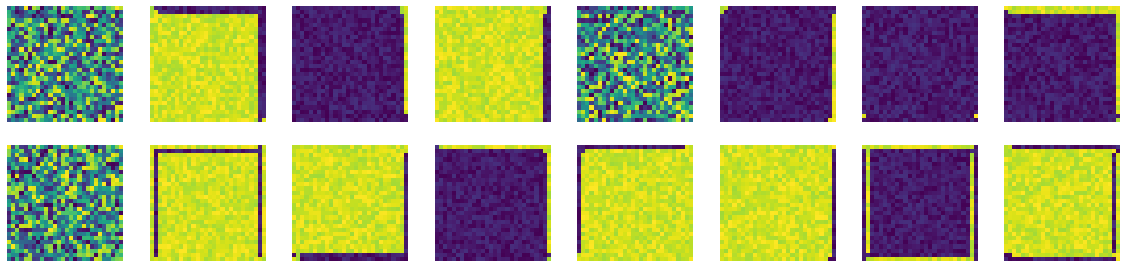

In [ ]:
conv_layer = LayerVisualisation(model, 0) ## First convolutional layer. Seems to detect edges and corners.
show_filters(conv_layer,16)

Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))


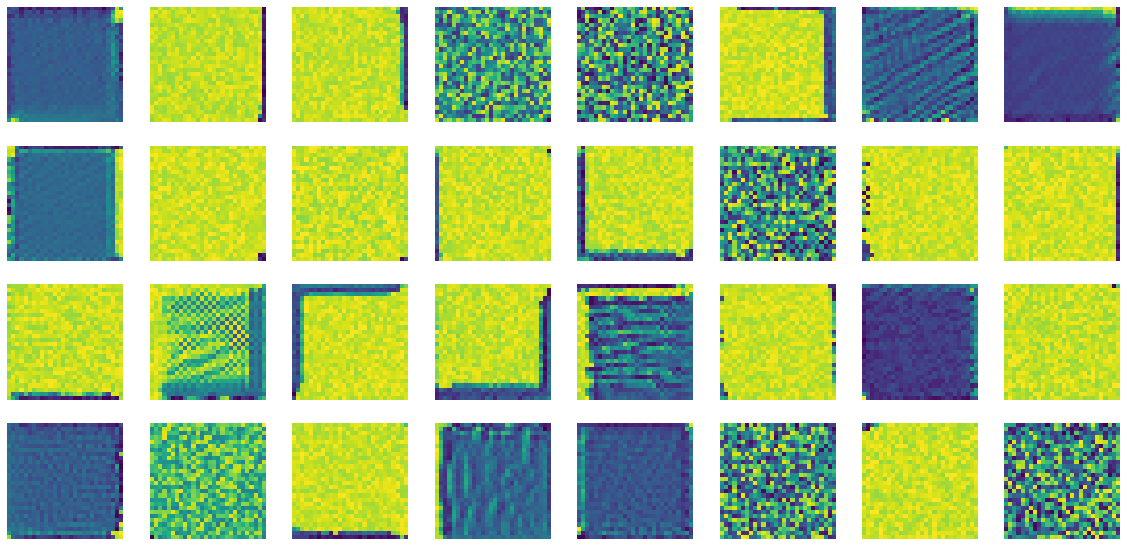

In [ ]:
conv_layer = LayerVisualisation(model, 2) ## Second convolutional layer.
show_filters(conv_layer, 32)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))


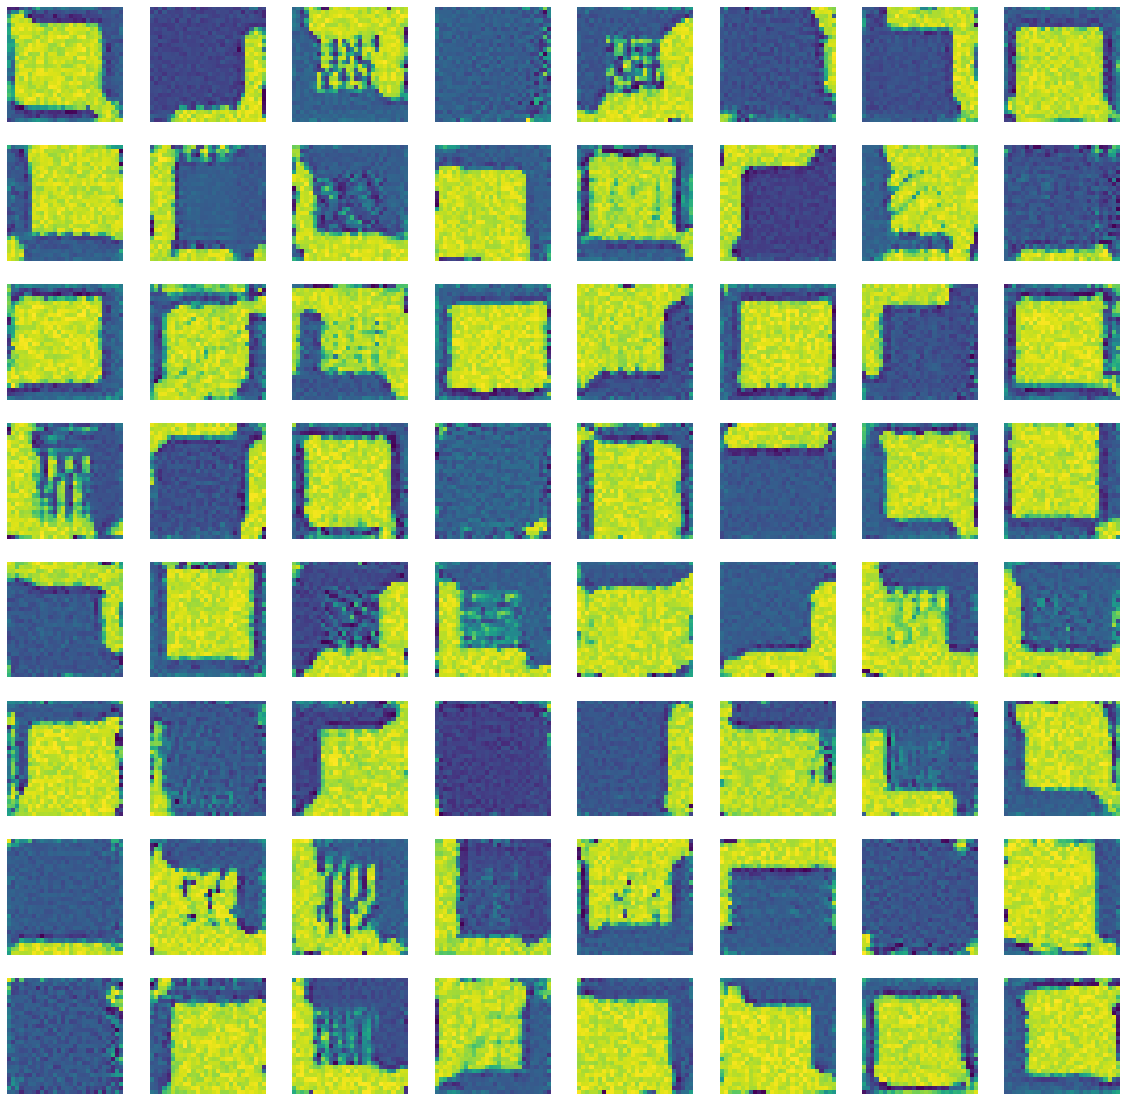

In [ ]:
conv_layer = LayerVisualisation(model, 3) ## Third convolutional layer. Seems to detect more complex shapes
show_filters(conv_layer, 64)

Dropout2d(p=0.4, inplace=False)


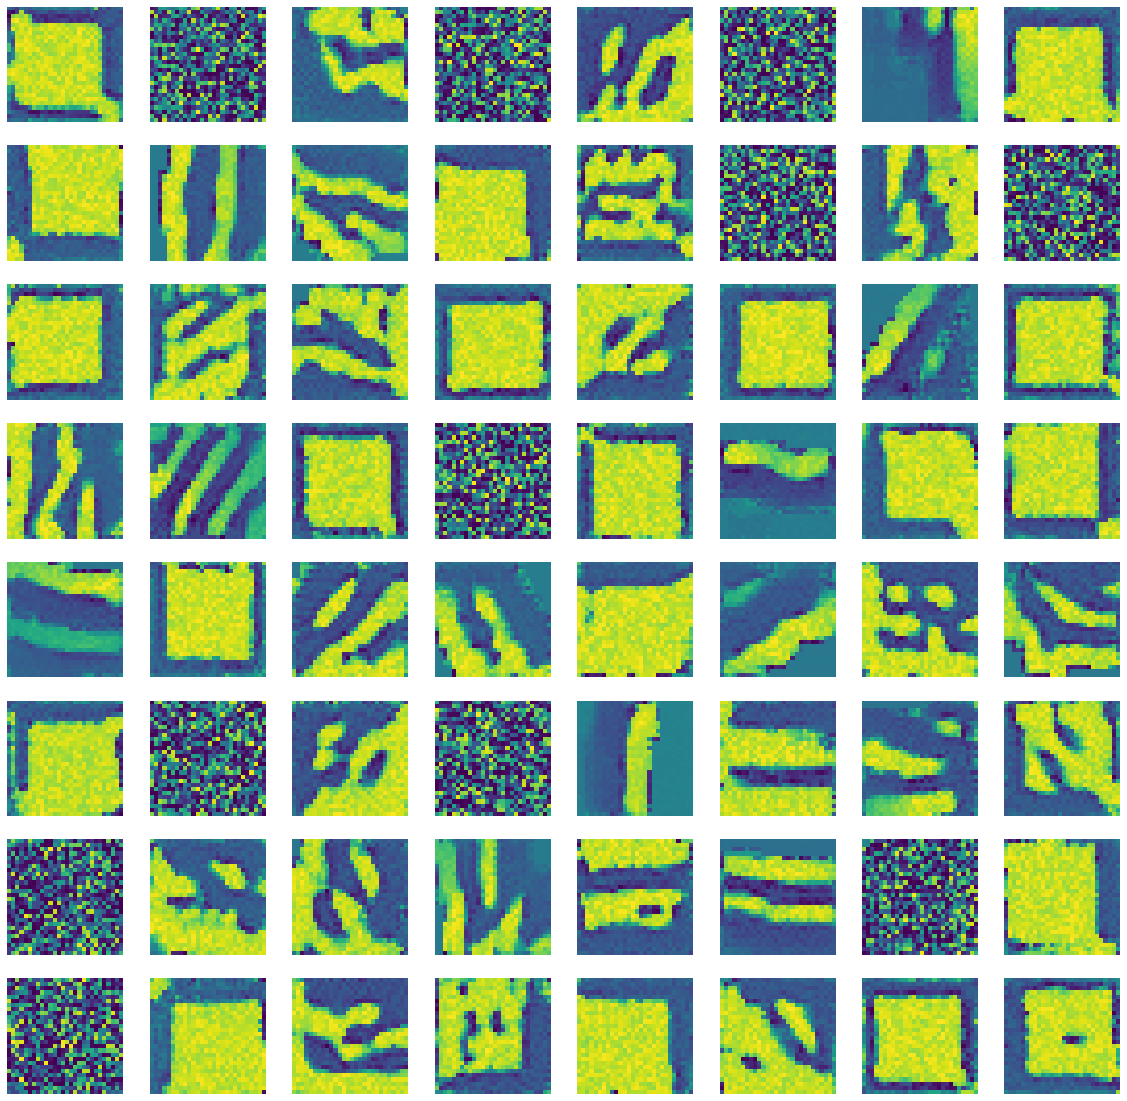

In [ ]:
conv_layer = LayerVisualisation(model, 7) ## Dropout layer. Some filters are randomly disregarded to help prevent overfitting.
show_filters(conv_layer,64)

Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))


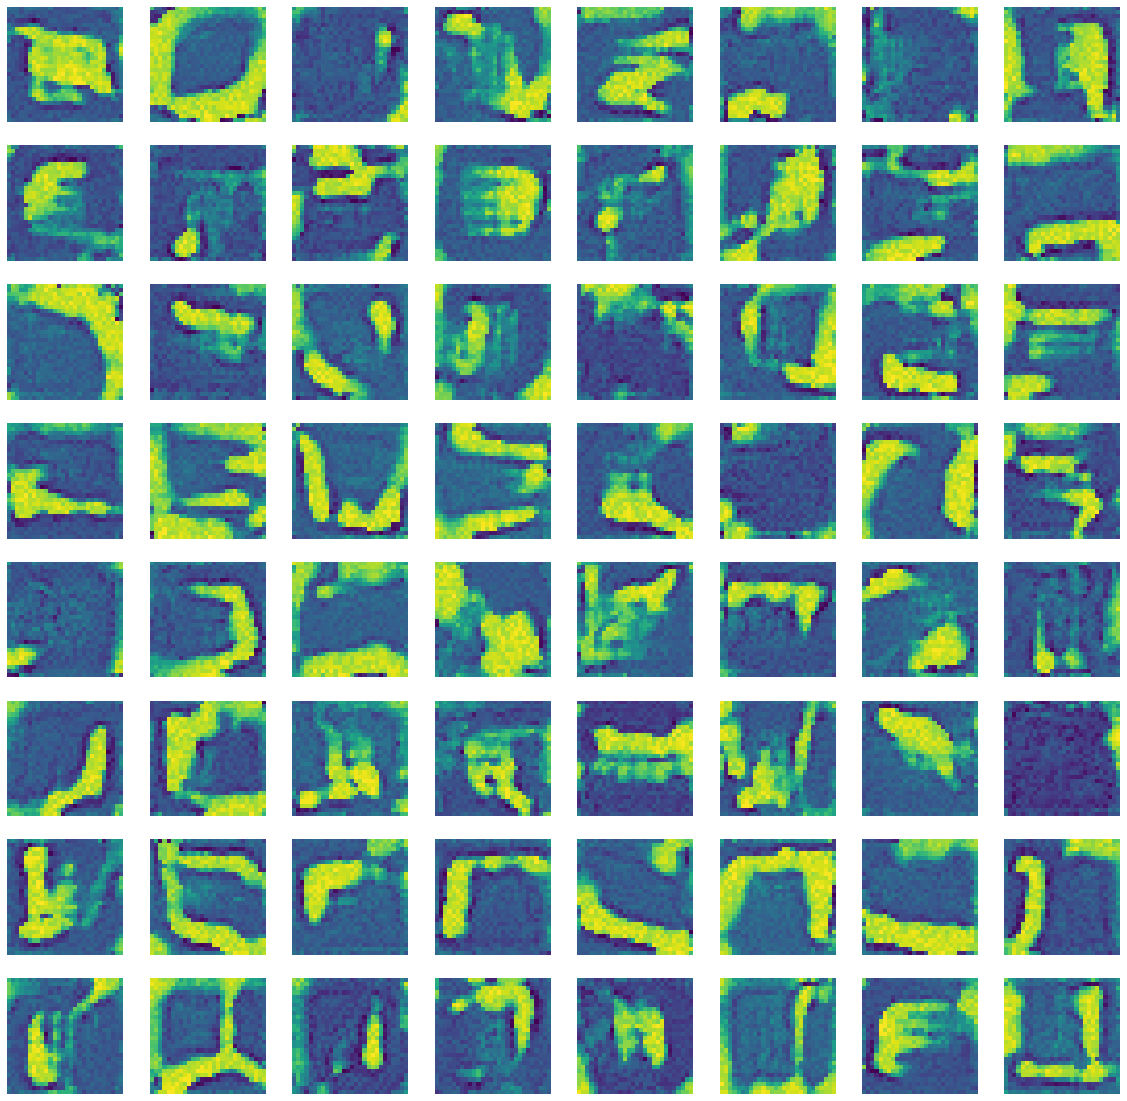

In [ ]:
conv_layer = LayerVisualisation(model, 4) ## Fourth convolutional layer - curves and complex shapes are being detected.
show_filters(conv_layer, 64)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


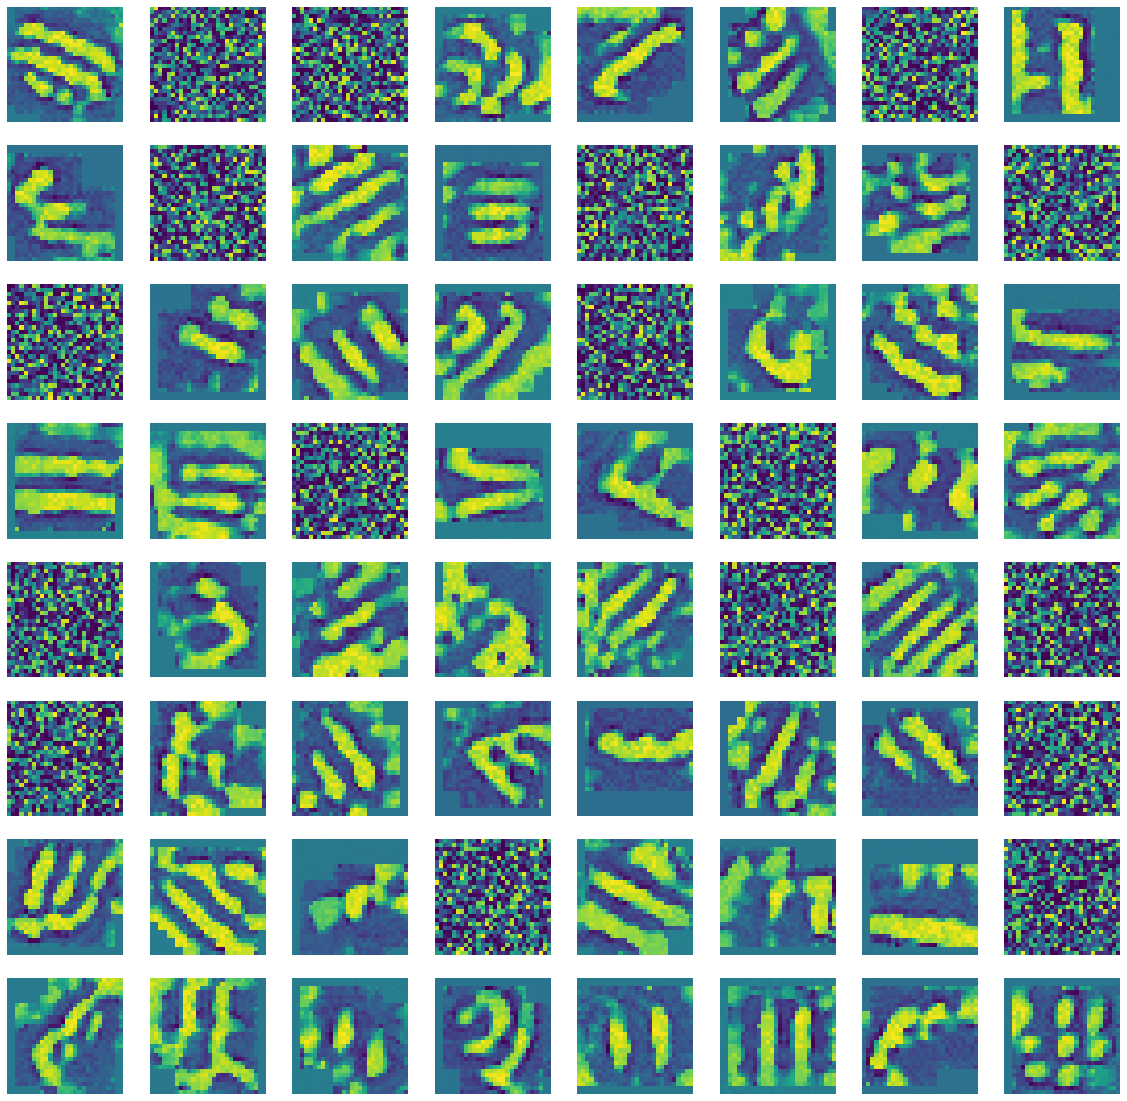

In [ ]:
conv_layer = LayerVisualisation(model, 1) ## Pooling layer (second) layer
show_filters(conv_layer, 64)

Linear(in_features=576, out_features=128, bias=True)


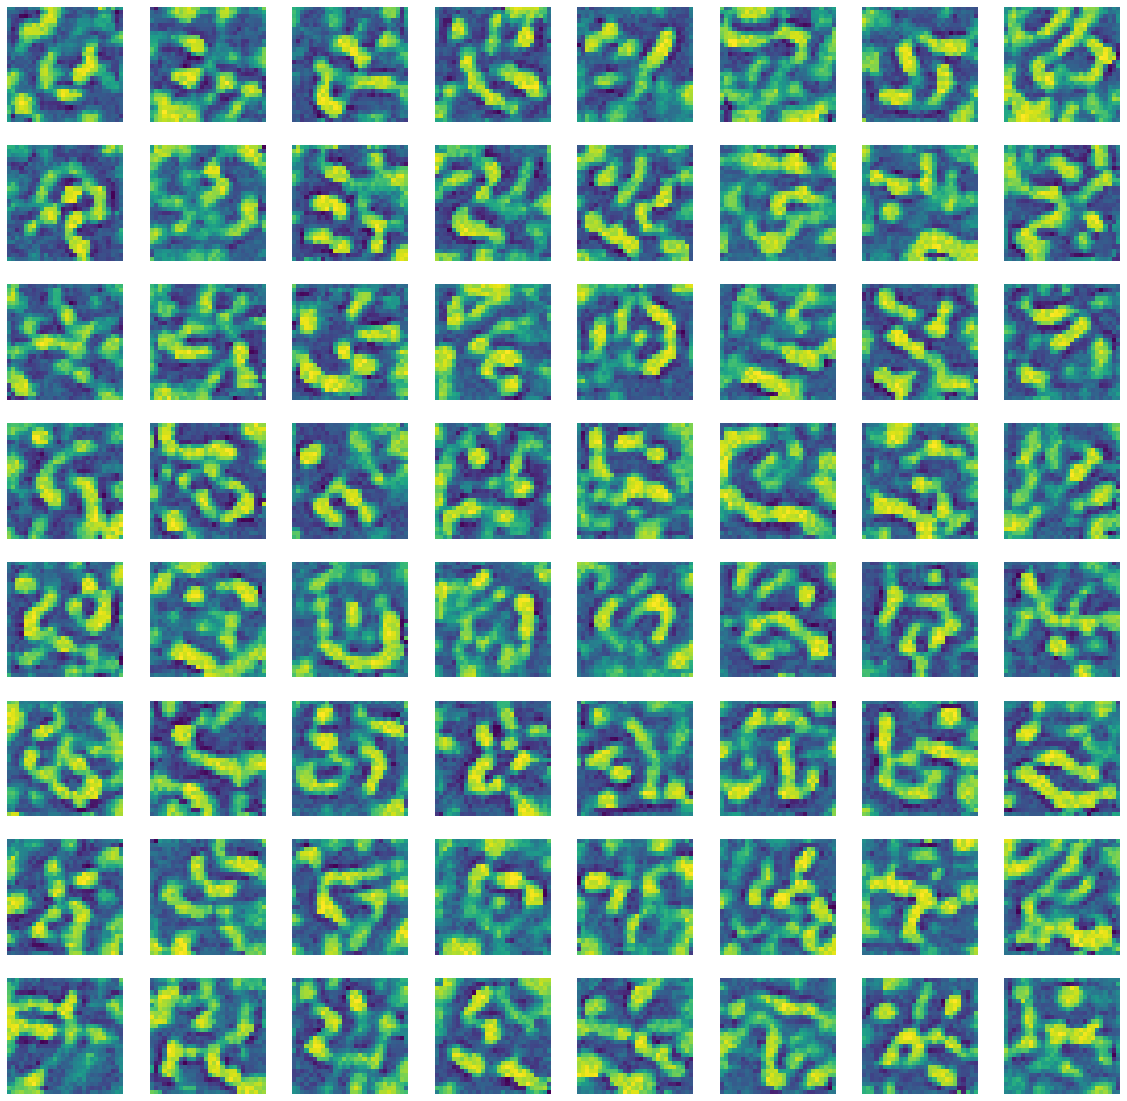

In [ ]:
conv_layer = LayerVisualisation(model, 5) ## First linear layer
show_filters(conv_layer, 64)

Linear(in_features=128, out_features=10, bias=True)


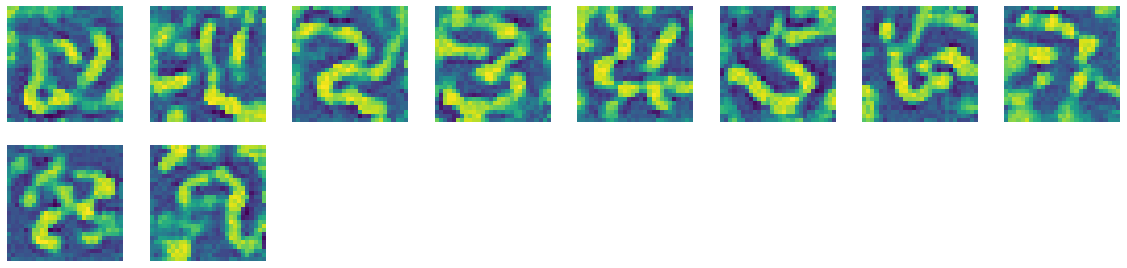

In [ ]:
conv_layer = LayerVisualisation(model, 6) ## Final linear layer - 10 outputs for 10 digits.
show_filters(conv_layer, 10)

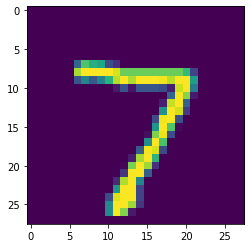

In [ ]:
with torch.no_grad():
  image, label = next(iter(valid_loader))
  model(image)

plt.imshow(image.squeeze())

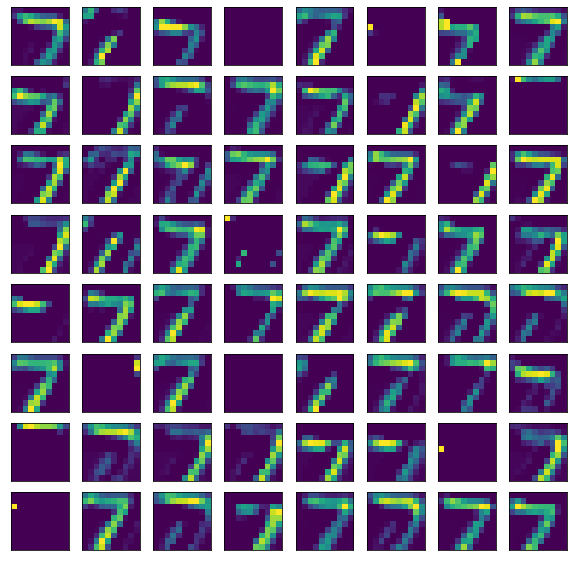

In [ ]:
fig = plt.figure(figsize=(10, 10)) 

for filter, map in enumerate(conv_layer.activations):
  ax = fig.add_subplot(8, 8, filter+1, xticks=[], yticks=[])
  ax.imshow(map)